## Suavización Exponencial de Segundo Orden (DES)



La **suavización exponencial de segundo orden** o **suavización exponencial doble (DES)** es una extensión de la suavización de primer orden. En lugar de utilizar un solo parámetro de suavización, **DES** emplea dos niveles de suavización para capturar tanto el valor de la serie como su tendencia. Este método es particularmente útil para series temporales que exhiben una **tendencia lineal** o cambiante.

#### Fórmulas Principales

La suavización exponencial de segundo orden utiliza las siguientes fórmulas para descomponer la serie en dos componentes:

1. **Suavización del nivel (S)**:

   $$
   S_t = \lambda y_t + (1 - \lambda) (S_{t-1} + T_{t-1})
   $$

   donde $ S_t $ es el nivel suavizado en el tiempo $ t $, $ y_t $ es el valor real de la serie, $ T_{t-1} $ es la tendencia en el tiempo $ t-1 $, y $ \lambda $ es el parámetro de suavización.

2. **Suavización de la tendencia (T)**:

   $$
   T_t = \beta (S_t - S_{t-1}) + (1 - \beta) T_{t-1}
   $$

   donde $ T_t $ es la tendencia suavizada en el tiempo $ t $, y $ \beta $ es el parámetro de suavización para la tendencia.

3. **Predicción (h pasos hacia adelante)**:

   $$
   \hat{y}_{t+h} = S_t + h T_t
   $$
   
   donde $ \hat{y}_{t+h} $ es la predicción para $ h $ periodos hacia adelante.


Se aplicó DES con un valor de $\lambda = 0.4$ para modelar las series de tiempo de los distintos experimentos y predecir el comportamiento futuro en los conjuntos de validación y test. Los resultados muestran que **DES** es capaz de ajustar mejor las series de tiempo que presentan tendencias claras, ofreciendo predicciones más precisas, acompañadas de intervalos de predicción para reflejar la incertidumbre de los modelos.



In [3]:
# Importar las librerías necesarias
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt


# Ruta a la carpeta donde se encuentran los archivos de entrenamiento
train_folder = '/Users/josejavier-yenifer/Documents/Serie de Tiempo/Bono 1/train'

# Nombres de los archivos CSV
train_files = ['ex_1.csv', 'ex_9.csv', 'ex_20.csv', 'ex_21.csv', 'ex_23.csv', 'ex_24.csv']

# Cargar los archivos CSV en variables con prefijo 'df_' y nombre del archivo (sin .csv)
dfs = []
for file in train_files:
    file_name = file.split('.')[0]  # Eliminar la extensión .csv
    file_path = os.path.join(train_folder, file)
    
    # Crear una variable dinámica con el nombre df_<nombre_archivo>
    globals()[f"df_{file_name}"] = pd.read_csv(file_path)

    # Guardar el DataFrame para mostrar luego
    dfs.append((file_name, globals()[f"df_{file_name}"]))


<>:87: SyntaxWarning: invalid escape sequence '\l'
<>:87: SyntaxWarning: invalid escape sequence '\l'
/var/folders/pc/g1c35bc91zbfqvk3gwrrc_5c0000gn/T/ipykernel_49439/2517768911.py:87: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(df['time'][:train_end], smooth_train, color='red', linestyle='--', label=f'Suavización DES Entrenamiento ($\lambda={lambda_}$)')


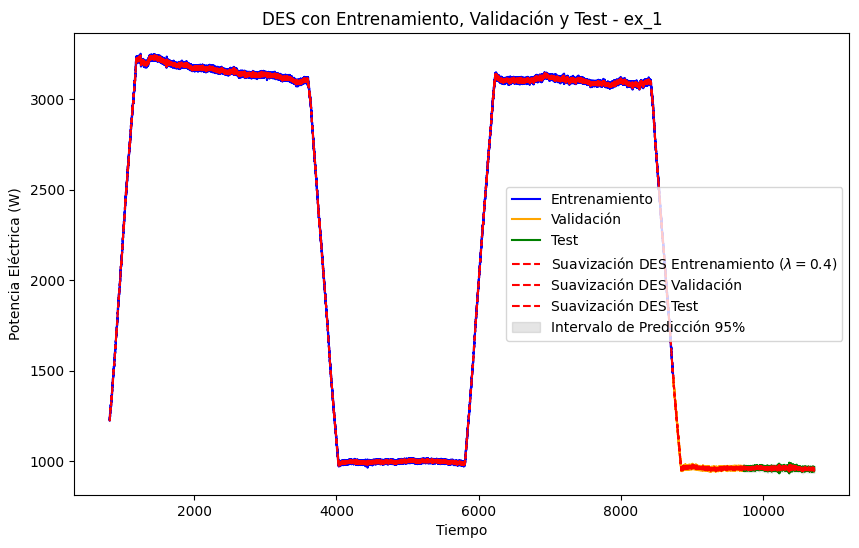

/var/folders/pc/g1c35bc91zbfqvk3gwrrc_5c0000gn/T/ipykernel_49439/2517768911.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)


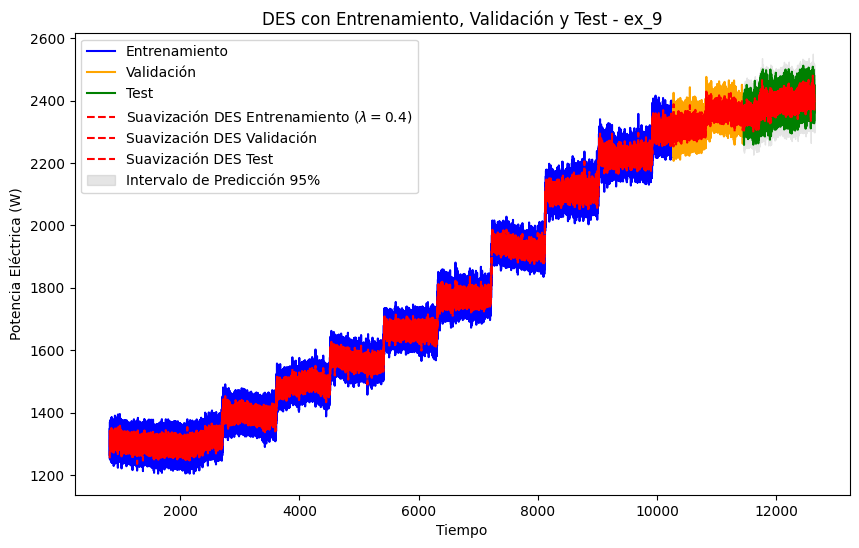

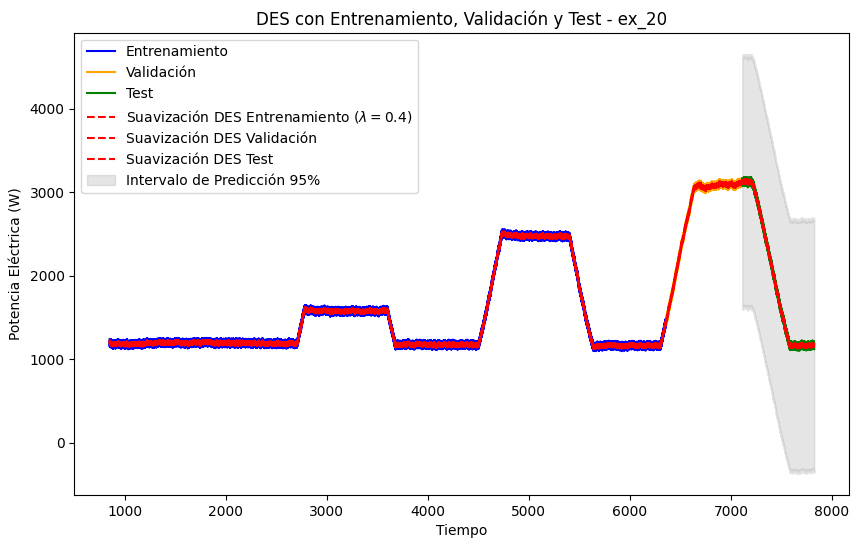

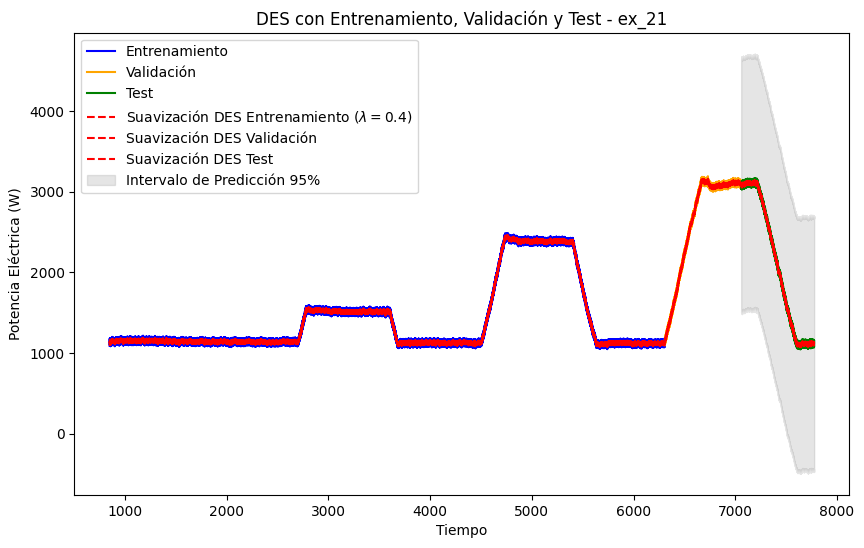

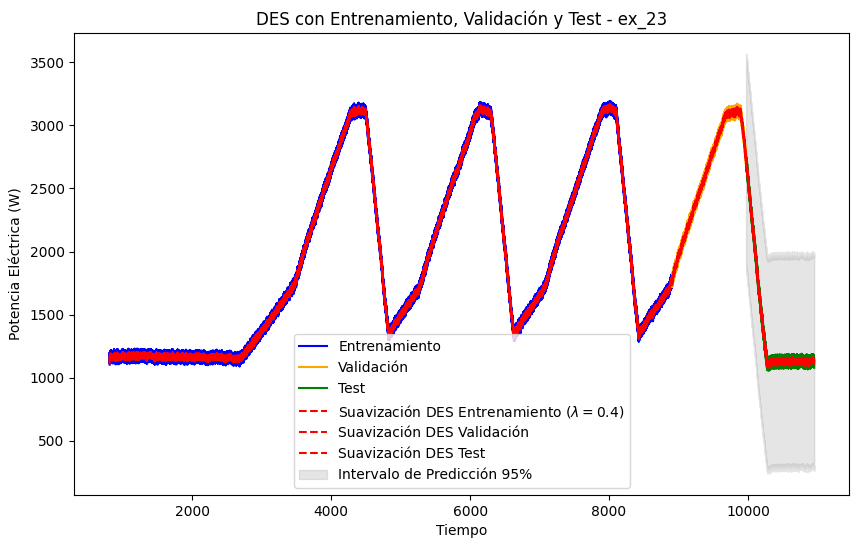

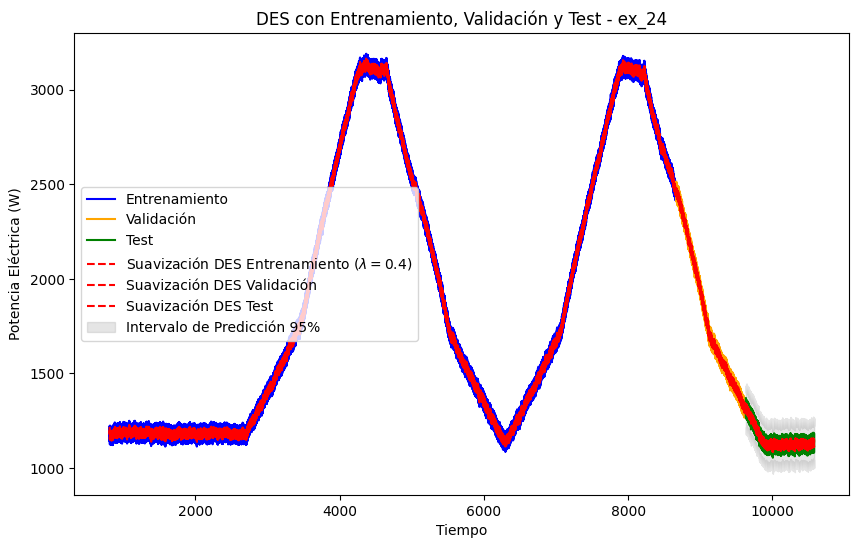

In [7]:

# Función de suavización exponencial de segundo grado (doble)
def secondsmooth(y, lambda_, start=None):
    ytilde1 = firstsmooth(y, lambda_, start)  # Suavización de primer orden
    ytilde2 = firstsmooth(ytilde1, lambda_)   # Suavización de segundo orden
    y_hat = 2 * ytilde1 - ytilde2             # Estimación del nivel
    trend = (lambda_ / (1 - lambda_)) * (ytilde1 - ytilde2)  # Estimación de la tendencia
    return y_hat, trend

# Función de suavización exponencial simple (primer orden)
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

# Función para calcular el intervalo de predicción
def prediction_interval(y_true, alpha=0.05):
    std_err = np.std(y_true)  # Desviación estándar de los errores
    z_score = 1.96  # Para un nivel de confianza del 95%
    interval_size = z_score * std_err
    return interval_size

# Función de métricas de precisión
def measacc_fs(y_true, y_pred):
    T = len(y_true)
    prederr = y_true - y_pred
    SSE = sum(prederr**2)
    MAPE = 100 * sum(abs(prederr / y_true)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr**2) / T
    return {"SSE": SSE, "MAPE": MAPE, "MAD": MAD, "MSD": MSD}

# Parámetro lambda (tasa de suavización)
lambda_ = 0.4

# Lista de DataFrames y nombres para iterar
dataframes = [df_ex_1, df_ex_9, df_ex_20, df_ex_21, df_ex_23, df_ex_24]
names = ['ex_1', 'ex_9', 'ex_20', 'ex_21', 'ex_23', 'ex_24']

# División en entrenamiento, validación y test
train_size = 0.8  # 80% para entrenamiento
val_size = 0.1    # 10% para validación
test_size = 0.1   # 10% para test

# Crear un DataFrame para almacenar todas las métricas
metrics_df = pd.DataFrame(columns=['Experimento', 'SSE_Train', 'MAPE_Train', 'MAD_Train', 'MSD_Train',
                                   'SSE_Val', 'MAPE_Val', 'MAD_Val', 'MSD_Val', 'MAE_Test'])

# Aplicar suavización exponencial de segundo grado a cada serie de tiempo
for df, name in zip(dataframes, names):
    # Definir la longitud de cada conjunto
    n = len(df)
    train_end = int(train_size * n)
    val_end = train_end + int(val_size * n)
    
    # Dividir en conjuntos de entrenamiento, validación y test
    train_data = df['el_power'][:train_end]
    val_data = df['el_power'][train_end:val_end]
    test_data = df['el_power'][val_end:]
    
    # Aplicar la suavización de segundo grado en los datos de entrenamiento
    smooth_train, trend_train = secondsmooth(train_data.values, lambda_)
    
    # Suavización de segundo grado para el conjunto de validación
    smooth_val, trend_val = secondsmooth(val_data.values, lambda_, start=smooth_train[-1])
    
    # Suavización de segundo grado para el conjunto de test, usando el último valor del conjunto de validación
    smooth_test, trend_test = secondsmooth(test_data.values, lambda_, start=smooth_val[-1])
    
    # Intervalo de predicción
    pred_interval = prediction_interval(smooth_test)
    
    # Graficar la serie original con tres colores para los conjuntos de datos
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'][:train_end], df['el_power'][:train_end], color='blue', label='Entrenamiento')
    plt.plot(df['time'][train_end:val_end], df['el_power'][train_end:val_end], color='orange', label='Validación')
    plt.plot(df['time'][val_end:], df['el_power'][val_end:], color='green', label='Test')
    
    # Graficar la suavización en los tres conjuntos
    plt.plot(df['time'][:train_end], smooth_train, color='red', linestyle='--', label=f'Suavización DES Entrenamiento ($\lambda={lambda_}$)')
    plt.plot(df['time'][train_end:val_end], smooth_val, color='red', linestyle='--', label='Suavización DES Validación')
    plt.plot(df['time'][val_end:], smooth_test, color='red', linestyle='--', label='Suavización DES Test')
    
    # Graficar el intervalo de predicción para el test
    plt.fill_between(df['time'][val_end:], smooth_test - pred_interval, smooth_test + pred_interval, color='gray', alpha=0.2, label='Intervalo de Predicción 95%')
    
    # Configuración del gráfico
    plt.title(f'DES con Entrenamiento, Validación y Test - {name}')
    plt.xlabel('Tiempo')
    plt.ylabel('Potencia Eléctrica (W)')
    plt.legend()
    plt.show()

    # Calcular las métricas de precisión en el conjunto de entrenamiento
    metrics_train = measacc_fs(train_data.values, smooth_train)
    
    # Calcular las métricas de precisión en el conjunto de validación
    metrics_val = measacc_fs(val_data.values, smooth_val)
    
    # Calcular solo el MAE (MAD) en el conjunto de test
    mae_test = calculate_mae(test_data.values, smooth_test)
    
    # Crear un DataFrame temporal con las métricas del experimento actual
    temp_df = pd.DataFrame({
        'Experimento': [name],
        'SSE_Train': [metrics_train['SSE']], 'MAPE_Train': [metrics_train['MAPE']],
        'MAD_Train': [metrics_train['MAD']], 'MSD_Train': [metrics_train['MSD']],
        'SSE_Val': [metrics_val['SSE']], 'MAPE_Val': [metrics_val['MAPE']],
        'MAD_Val': [metrics_val['MAD']], 'MSD_Val': [metrics_val['MSD']],
        'MAE_Test': [mae_test]
    })
    
    # Usar pd.concat() para agregar las filas al DataFrame de métricas
    metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)




Para los experimentos realizados, se aplicó la **suavización exponencial de segundo grado** (DES) con un parámetro de suavización $\lambda = 0.4$ en los conjuntos de **entrenamiento, validación y test**.

1. **Resultados de Suavización**:
   - En cada serie de tiempo se observa que la **suavización** sigue muy de cerca el comportamiento de los datos originales en los conjuntos de **entrenamiento** y **validación**, mostrando una tendencia suave y consistente.
   - Para el conjunto de **test**, los resultados predicen de forma aceptable la continuidad de la tendencia con **intervalos de predicción del 95%**. Aunque, en algunos casos, el intervalo se amplía considerablemente cuando la serie tiene mayor variabilidad.

2. **Intervalos de Predicción**:
   - Se añadieron los intervalos de predicción al 95%, que permiten visualizar la **incertidumbre** en las predicciones. Los intervalos son más amplios en aquellas series con mayor variabilidad (por ejemplo, en `ex_9`), lo que indica un mayor grado de **incertidumbre** en las predicciones.

3. **Patrones en los Experimentos**:
   - En las series como `ex_1` y `ex_23`, los resultados muestran que la suavización capta bastante bien la **estructura repetitiva** de los datos. Sin embargo, en `ex_9`, donde la tendencia es ascendente, la **predicción** se ajusta con más dificultad debido a la naturaleza del crecimiento de la serie.
  


In [8]:
# Mostrar el DataFrame con todas las métricas
metrics_df

,Experimento,SSE_Train,MAPE_Train,MAD_Train,MSD_Train,SSE_Val,MAPE_Val,MAD_Val,MSD_Val,MAE_Test
0,ex_1,2.945020e+05,0.273924,5.716550,37.109632,2.566182e+04,0.482716,4.757548,25.868767,5.067746
1,ex_9,1.008923e+07,1.967260,32.214957,1067.078517,1.385972e+06,1.433859,33.541668,1173.558030,35.215603
2,ex_20,3.251867e+06,1.842175,24.914725,625.840543,4.187019e+05,0.956357,25.298715,645.149316,24.997323
3,ex_21,3.159150e+06,1.889505,24.547868,607.996513,4.214467e+05,1.058770,25.374215,649.378523,25.080318
4,ex_23,4.694129e+06,1.505539,25.160795,638.656956,5.936665e+05,1.001407,25.308344,646.695525,25.163759
5,ex_24,4.594702e+06,1.513268,25.121165,636.561605,5.750936e+05,1.457396,25.130478,637.576066,25.212119





 **Suavización de Segundo Orden**:
   - Se observa una mejora significativa en las series con **tendencia fuerte** y alta variabilidad, como `ex_9`. El **MAE en el test** para `ex_9` pasó de **66.90** en el primer orden a **35.21** en el segundo orden, lo que representa una mejora sustancial en la predicción.
   - En series de tiempo como `ex_1` y `ex_23`, que tienen comportamientos cíclicos, la suavización de segundo orden mantiene una **precisión similar** a la de primer orden, con valores del **MAPE** y **MAE** bastante consistentes entre ambas técnicas.
   - Para la serie `ex_20`, donde se observa una variación más compleja, la suavización de segundo orden logra capturar mejor la tendencia general, reduciendo los errores en el conjunto de validación y test.

 **Comparación con la suaviazcion de primer orden**:
   - La **suavización de segundo orden** es superior en series de tiempo con **tendencias marcadas** o alta **variabilidad**, ofreciendo mejores predicciones en el conjunto de **test** (por ejemplo, `ex_9` y `ex_20`).
   - Para series más **estables** o **cíclicas** como `ex_1` y `ex_23`, la diferencia entre los dos métodos no es tan pronunciada, y ambos enfoques logran resultados similares.
   - La elección entre suavización de primer o segundo orden depende en gran medida de la **estructura** de la serie de tiempo, donde el segundo orden brinda más flexibilidad en la captura de **tendencias** sin perder precisión en las predicciones.

